<a href="https://colab.research.google.com/github/FGalvao77/-Time-series---Forecasting-com-Prophet-previsao-de-consumo-de-energia-eletrica/blob/main/%5BTime_series%5D_Forecasting_com_Prophet_previs%C3%A3o_de_consumo_de_energia_el%C3%A9trica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **[Time series] - Forecastig com `Prophet`: previsão de consumo de energia elétrica**
---
---

- previsão de consumo de energia elétrica

In [1]:
%%capture
!pip install prophet -U

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime as dt 

from prophet import Prophet

from sklearn.metrics import (mean_absolute_error as mae,
                             mean_squared_error as mse)

from pylab import rcParams

%matplotlib inline 
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 14, 9

In [3]:
def mean_absolute_percentage_error(y_true:str, y_pred:str) -> str:
    '''
    Função:
    - calcula o MAPE dado y_true e y_pred
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)

In [4]:
!curl https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv >> PJME_hourly.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3974k  100 3974k    0     0  8350k      0 --:--:-- --:--:-- --:--:-- 8333k


In [5]:
!head PJME_hourly.csv

Datetime,PJME_MW
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [6]:
pjme = pd.read_csv(filepath_or_buffer='PJME_hourly.csv',
                   index_col=[0],
                   parse_dates=[0])

In [7]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [8]:
# instanciando a paleta de cores
color_pal = sns.color_palette()

# visualizando a paleta de cores
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

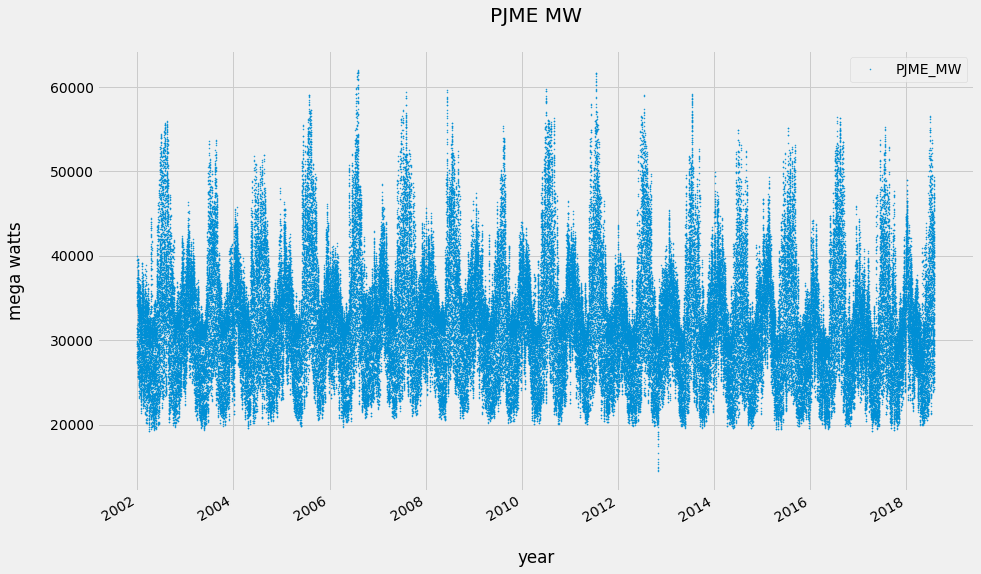

In [9]:
pjme.plot(
    style='.',
    ms=1,
    color=color_pal[0],
    title='PJME MW\n'
)

plt.xlabel('\nyear')
plt.ylabel('mega watts\n')
plt.legend(loc='best')
plt.show()

In [10]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 
                'Sunday'], ordered=True
)

In [11]:
def create_features(df:str, label:str=None) -> str:
    '''
    Função:
     - criar recursos de série temporal a partir do índice de data e hora
    '''
    df = df.copy()

    df['date'] = df.index

    df['hour'] = df['date'].dt.hour 
    df['dayOfWeek'] = df['date'].dt.dayofweek 
    df['weekday'] = df['date'].dt.day_name()

    df['weekday'] = df['weekday'].astype(cat_type)

    df['quarter'] = df['date'].dt.quarter

    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['dayOfYear'] = df['date'].dt.dayofyear
    df['dayOfMonth'] = df['date'].dt.day
    df['weekOfYear'] = df['date'].dt.weekofyear

    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1_300

    df['season'] = pd.cut(df['date_offset'], 
                          [0, 300, 602, 900, 1_300],
                          labels=['Spring',
                                  'Summer',
                                  'Fall',
                                  'Winter'])
    
    X = df[['hour', 'dayOfWeek', 'quarter', 'month', 'year', 'dayOfYear', 
            'dayOfMonth', 'weekOfYear', 'weekday', 'season']]

    if label:
        y = df[label]
        return X, y
        
    return X

In [12]:
X, y = create_features(df=pjme, label='PJME_MW')

In [13]:
X.head()

,hour,dayOfWeek,quarter,month,year,dayOfYear,dayOfMonth,weekOfYear,weekday,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter


In [14]:
y.head()

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
Name: PJME_MW, dtype: float64

In [15]:
features_and_target = pd.concat(
    [X, y], axis=1
)

In [16]:
features_and_target.head()

,hour,dayOfWeek,quarter,month,year,dayOfYear,dayOfMonth,weekOfYear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


In [17]:
features_and_target.columns

Index(['hour', 'dayOfWeek', 'quarter', 'month', 'year', 'dayOfYear',
       'dayOfMonth', 'weekOfYear', 'weekday', 'season', 'PJME_MW'],
      dtype='object')

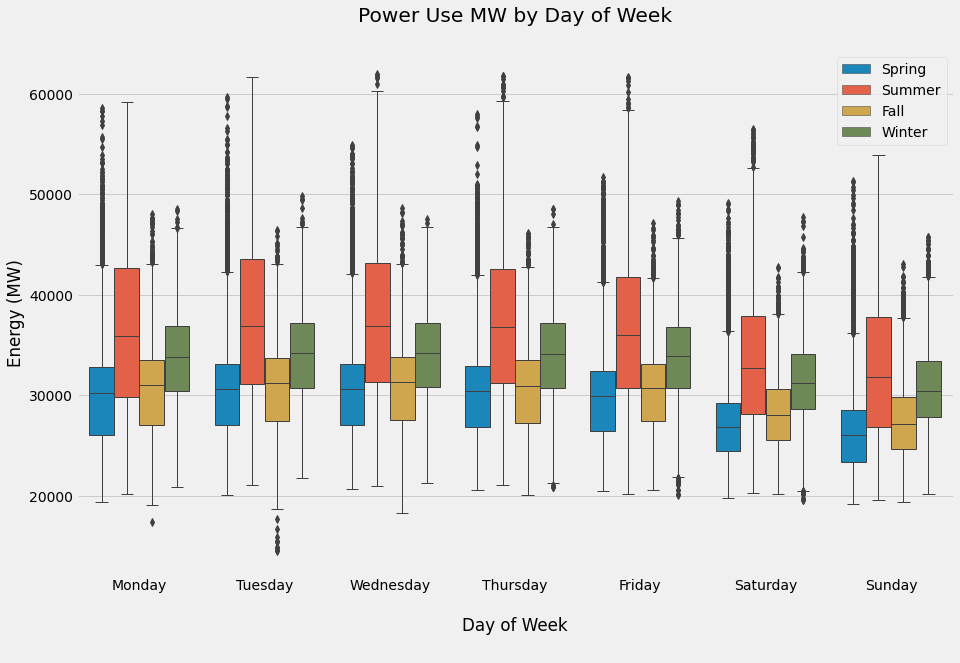

In [18]:
fig, ax = plt.subplots()

sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)

ax.set_title('Power Use MW by Day of Week\n')
ax.set_xlabel('\nDay of Week\n')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [19]:
split_date = '1-Jan-2015'

pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [20]:
len(pjme_train), len(pjme_test)

(113927, 31439)

In [21]:
pjme_train.tail(n=1)

,PJME_MW
Datetime,
2014-01-02,30159.0


In [22]:
pjme_test.head(n=1)

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0


In [23]:
# split_date = round(len(pjme.index) * 0.7)

# split_date

In [24]:
# pjme_train = pjme.iloc[:split_date].copy()
# pjme_test = pjme.iloc[split_date:].copy()

In [25]:
# len(pjme_train), len(pjme_test)

In [26]:
# pjme_train.tail(n=1)

In [27]:
# pjme_test.head(n=1)

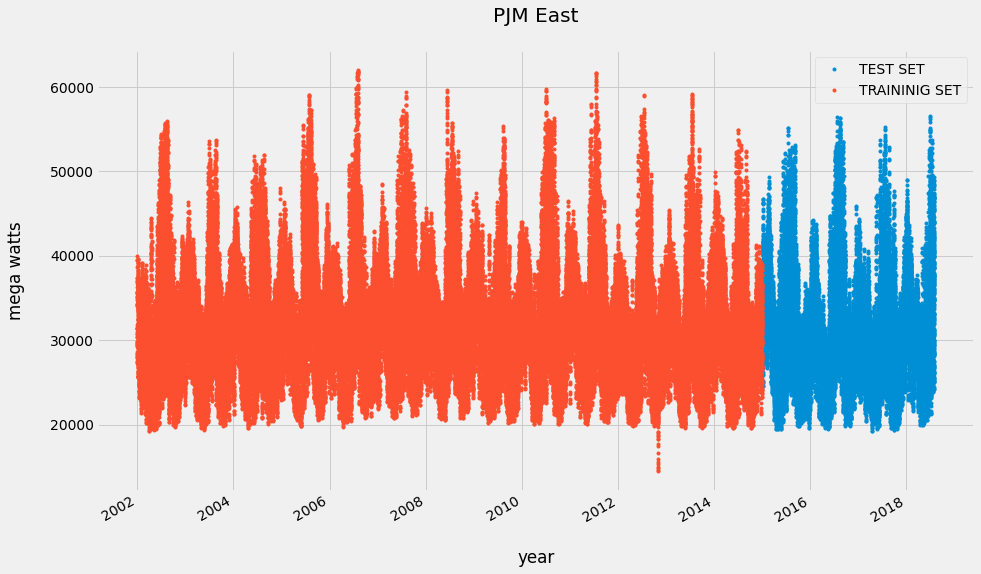

In [28]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAININIG SET'}), 
          how='outer') \
    .plot(title='PJM East\n', style='.')

plt.xlabel('\nyear')
plt.ylabel('mega watts\n')
plt.legend(loc='best')
plt.show()

O modelo do **Prophet** espera que o conjunto de dados seja nomeado de uma maneira específica. Vamos renomear nossas colunas do dataframe antes de aplicá-lo no modelo.

- `Datetime`: _ds_
- `target`: _y_

In [29]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [30]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [31]:
%%time
model = Prophet()

model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9_03nan/qhaoyjo_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9_03nan/xg417ght.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12857', 'data', 'file=/tmp/tmpp9_03nan/qhaoyjo_.json', 'init=/tmp/tmpp9_03nan/xg417ght.json', 'output', 'file=/tmp/tmpp9_03nan/prophet_modelzt8pouiu/prophet_model-20230224135554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 16.9 s, sys: 999 ms, total: 17.9 s
Wall time: 3min 1s


In [32]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [33]:
pjme_test_fcst = model.predict(df=pjme_test_prophet)

In [34]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31208.242211,24083.236210,33200.581813,31208.242211,31208.242211,-2823.783460,-2823.783460,-2823.783460,-4430.274591,...,1281.397220,1281.397220,1281.397220,325.093911,325.093911,325.093911,0.0,0.0,0.0,28384.458751
1,2015-01-01 02:00:00,31208.204190,22456.731852,31139.532568,31208.204190,31208.204190,-4328.051217,-4328.051217,-4328.051217,-5927.106157,...,1272.639135,1272.639135,1272.639135,326.415805,326.415805,326.415805,0.0,0.0,0.0,26880.152974
2,2015-01-01 03:00:00,31208.166170,21834.597800,30448.790141,31208.166170,31208.166170,-5199.726151,-5199.726151,-5199.726151,-6790.180837,...,1262.675516,1262.675516,1262.675516,327.779170,327.779170,327.779170,0.0,0.0,0.0,26008.440019
3,2015-01-01 04:00:00,31208.128150,21611.190092,30429.630431,31208.128150,31208.128150,-5341.341459,-5341.341459,-5341.341459,-6922.155403,...,1251.629913,1251.629913,1251.629913,329.184032,329.184032,329.184032,0.0,0.0,0.0,25866.786691
4,2015-01-01 05:00:00,31208.090129,22146.752646,31264.354214,31208.090129,31208.090129,-4667.089592,-4667.089592,-4667.089592,-6237.358087,...,1239.638080,1239.638080,1239.638080,330.630416,330.630416,330.630416,0.0,0.0,0.0,26541.000538


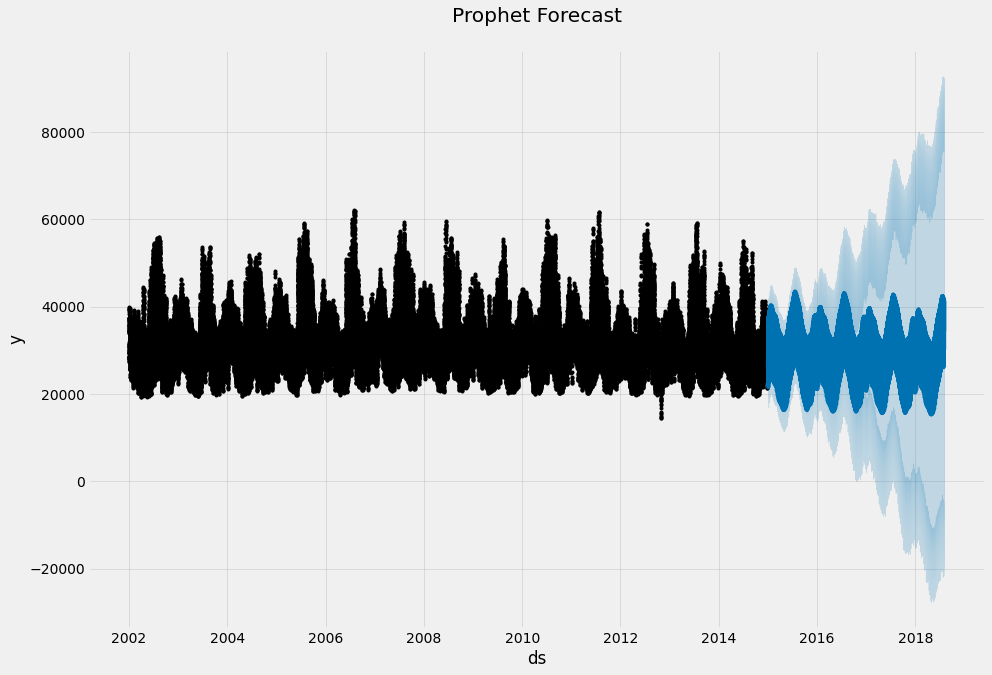

In [35]:
fig, ax = plt.subplots()

fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_title('Prophet Forecast\n')
plt.show()

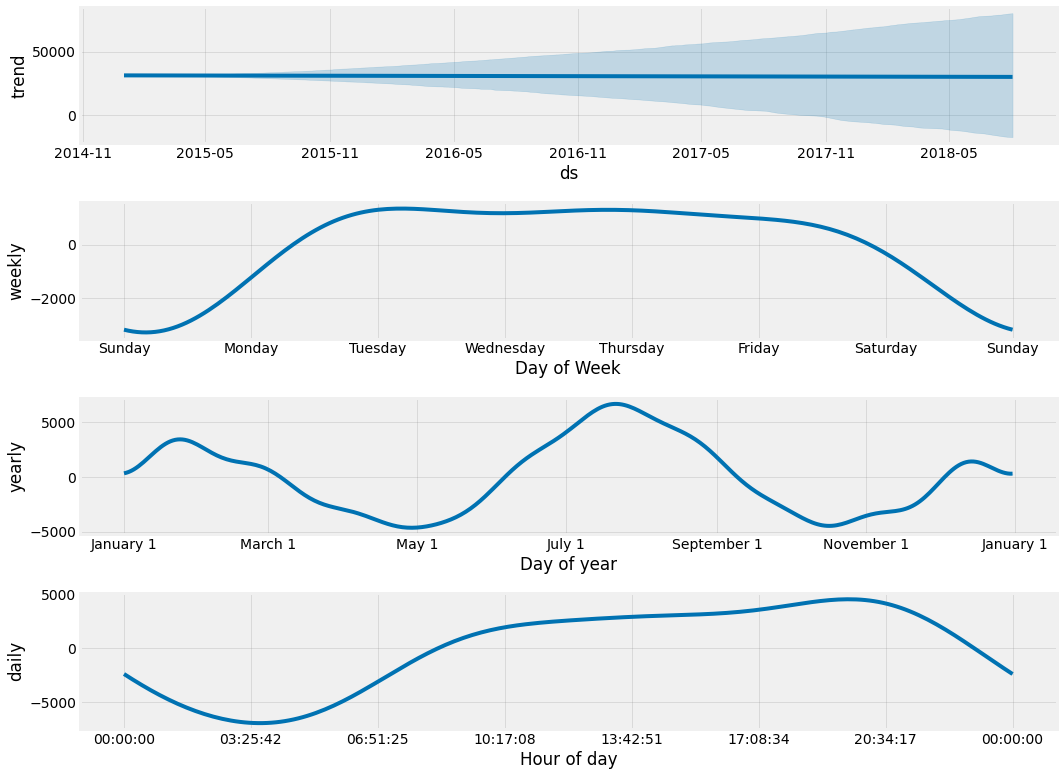

In [36]:
fig = model.plot_components(pjme_test_fcst, figsize=(15, 11))

plt.show()

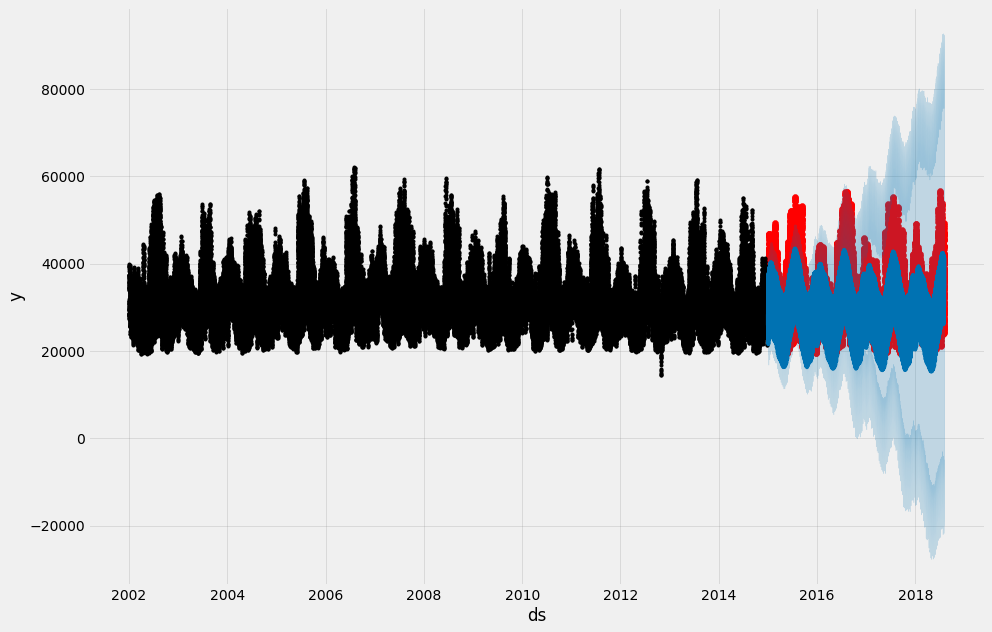

In [37]:
f, ax = plt.subplots()

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')

fig = model.plot(pjme_test_fcst, ax=ax)

In [38]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_pal

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

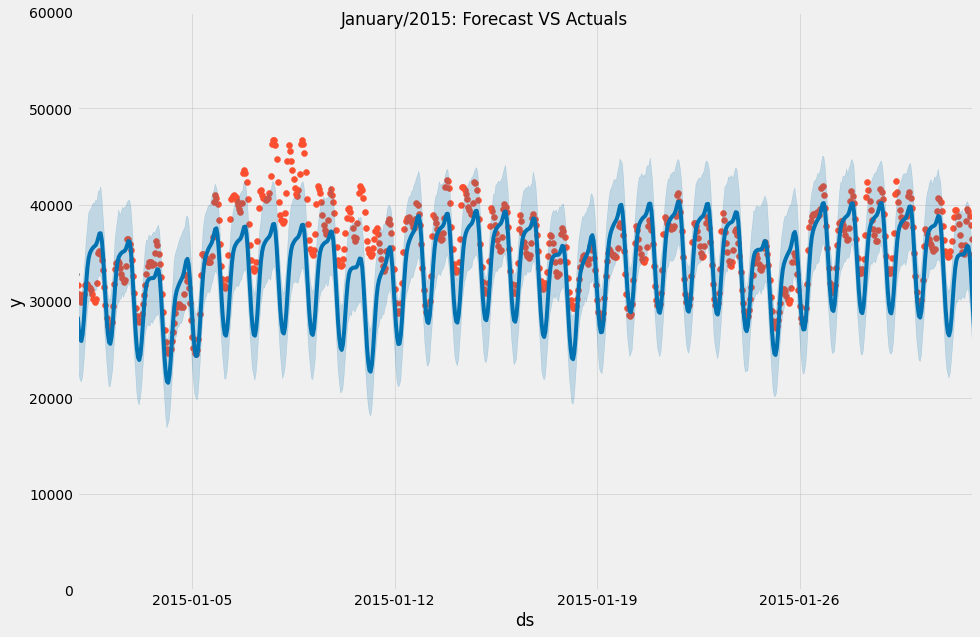

In [39]:
init = pd.to_datetime('01-01-2015', format = '%m-%d-%Y')
end = pd.to_datetime('02-01-2015', format = '%m-%d-%Y')

fig, ax = plt.subplots()
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=color_pal[1])

fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower=init, upper=end)
ax.set_ylim(0, 60_000)

plot = plt.suptitle('January/2015: Forecast VS Actuals\n')

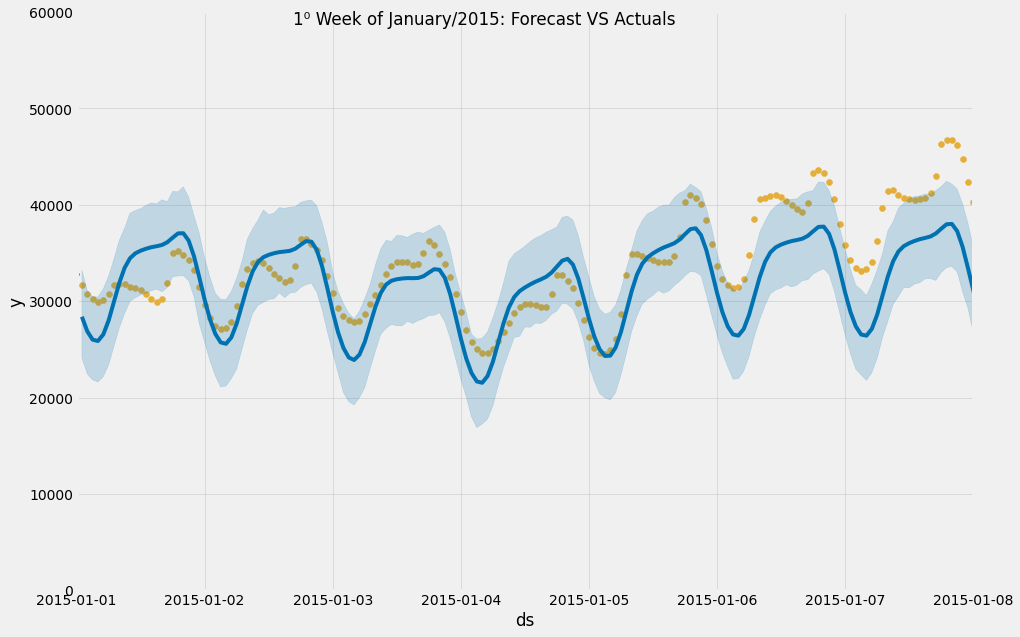

In [40]:
init = pd.to_datetime('01-01-2015', format = '%m-%d-%Y')
end = pd.to_datetime('01-08-2015', format = '%m-%d-%Y')

fig, ax = plt.subplots()
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=color_pal[2])

fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower=init, upper=end)
ax.set_ylim(0, 60_000)

plot = plt.suptitle('1⁰ Week of January/2015: Forecast VS Actuals\n')

In [41]:
np.sqrt(mse(y_true=pjme_test['PJME_MW'],
            y_pred=pjme_test_fcst['yhat'])).round(4)

6616.6216

In [42]:
mae(y_true=pjme_test['PJME_MW'], 
    y_pred=pjme_test_fcst['yhat']).round(4)

5182.7699

In [43]:
mape = mean_absolute_percentage_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test_fcst['yhat']
).round(4)

mape

16.5078

In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [45]:
CALENDAR = calendar()

holidays = CALENDAR.holidays(start=pjme.index.min(), 
                             end=pjme.index.max())

holiday_df = pd.DataFrame(data=holidays,
                          columns=['ds']) \
                          .assign(holiday='USFederalHoliday')

In [46]:
holidays

DatetimeIndex(['2002-01-21', '2002-02-18', '2002-05-27', '2002-07-04',
               '2002-09-02', '2002-10-14', '2002-11-11', '2002-11-28',
               '2002-12-25', '2003-01-01',
               ...
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-05-28', '2018-07-04'],
              dtype='datetime64[ns]', length=164, freq=None)

In [47]:
CALENDAR = calendar()

holidays = CALENDAR.holidays(start=pjme.index.min(), 
                             end=pjme.index.max(),
                             return_name=True)

holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday_name']) \
                          .assign(holiday='USFederalHoliday')

In [48]:
holiday_df['holiday_name'].value_counts()

Martin Luther King Jr. Day    17
Presidents Day                17
Memorial Day                  17
July 4th                      17
Labor Day                     16
Columbus Day                  16
Veterans Day                  16
Thanksgiving                  16
Christmas                     16
New Years Day                 16
Name: holiday_name, dtype: int64

In [49]:
holiday_df

,holiday_name,holiday
2002-01-21,Martin Luther King Jr. Day,USFederalHoliday
2002-02-18,Presidents Day,USFederalHoliday
2002-05-27,Memorial Day,USFederalHoliday
2002-07-04,July 4th,USFederalHoliday
2002-09-02,Labor Day,USFederalHoliday
...,...,...
2018-01-01,New Years Day,USFederalHoliday
2018-01-15,Martin Luther King Jr. Day,USFederalHoliday
2018-02-19,Presidents Day,USFederalHoliday
2018-05-28,Memorial Day,USFederalHoliday


In [50]:
CALENDAR = calendar()

holidays = CALENDAR.holidays(start=pjme.index.min(), 
                             end=pjme.index.max(),
                             return_name=True)

holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday']) \
                          .assign(holiday='USFederalHoliday')

In [51]:
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})

In [52]:
holiday_df.head()

,ds,holiday
0,2002-01-21,USFederalHoliday
1,2002-02-18,USFederalHoliday
2,2002-05-27,USFederalHoliday
3,2002-07-04,USFederalHoliday
4,2002-09-02,USFederalHoliday


In [53]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)

model_with_holidays.fit(df=pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9_03nan/_f9pqdrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp9_03nan/jt6_6uqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3988', 'data', 'file=/tmp/tmpp9_03nan/_f9pqdrn.json', 'init=/tmp/tmpp9_03nan/jt6_6uqb.json', 'output', 'file=/tmp/tmpp9_03nan/prophet_modelwb6ff790/prophet_model-20230224135857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 11.7 s, sys: 590 ms, total: 12.3 s
Wall time: 2min 4s


In [54]:
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

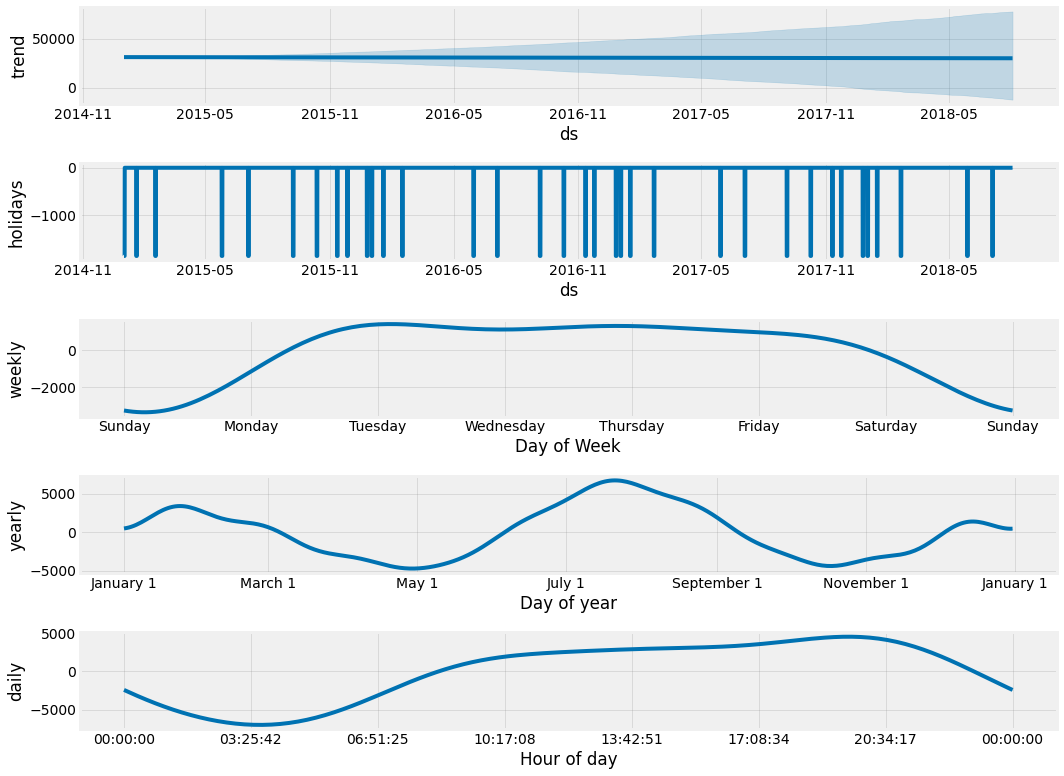

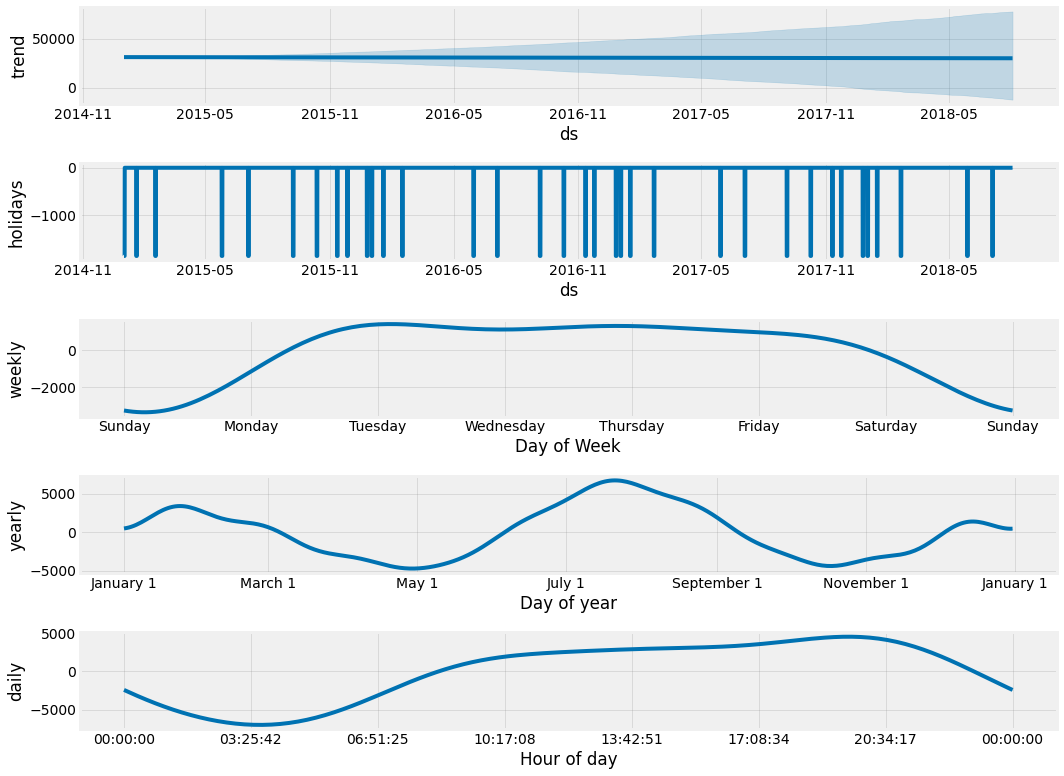

In [55]:
model_with_holidays.plot_components(
    fcst=pjme_test_fcst_with_hols,
    figsize=(15, 11)
)

In [56]:
pjme_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31261.208586,21919.693377,30932.478362,31261.208586,31261.208586,-1854.856614,-1854.856614,-1854.856614,-4538.702252,...,1293.665569,1293.665569,1293.665569,452.804365,452.804365,452.804365,0.0,0.0,0.0,26722.506333
1,2015-01-01 02:00:00,31261.171412,20437.857229,29322.705884,31261.171412,31261.171412,-1854.856614,-1854.856614,-1854.856614,-6042.140452,...,1285.881905,1285.881905,1285.881905,454.115357,454.115357,454.115357,0.0,0.0,0.0,25219.030960
2,2015-01-01 03:00:00,31261.134239,20104.557366,29029.050071,31261.134239,31261.134239,-1854.856614,-1854.856614,-1854.856614,-6913.279090,...,1276.525190,1276.525190,1276.525190,455.464171,455.464171,455.464171,0.0,0.0,0.0,24347.855149
3,2015-01-01 04:00:00,31261.097065,19843.290428,28579.011122,31261.097065,31261.097065,-1854.856614,-1854.856614,-1854.856614,-7054.619156,...,1265.729281,1265.729281,1265.729281,456.850836,456.850836,456.850836,0.0,0.0,0.0,24206.477910
4,2015-01-01 05:00:00,31261.059892,20391.206657,29608.057121,31261.059892,31261.059892,-1854.856614,-1854.856614,-1854.856614,-6380.388150,...,1253.644878,1253.644878,1253.644878,458.275380,458.275380,458.275380,0.0,0.0,0.0,24880.671742


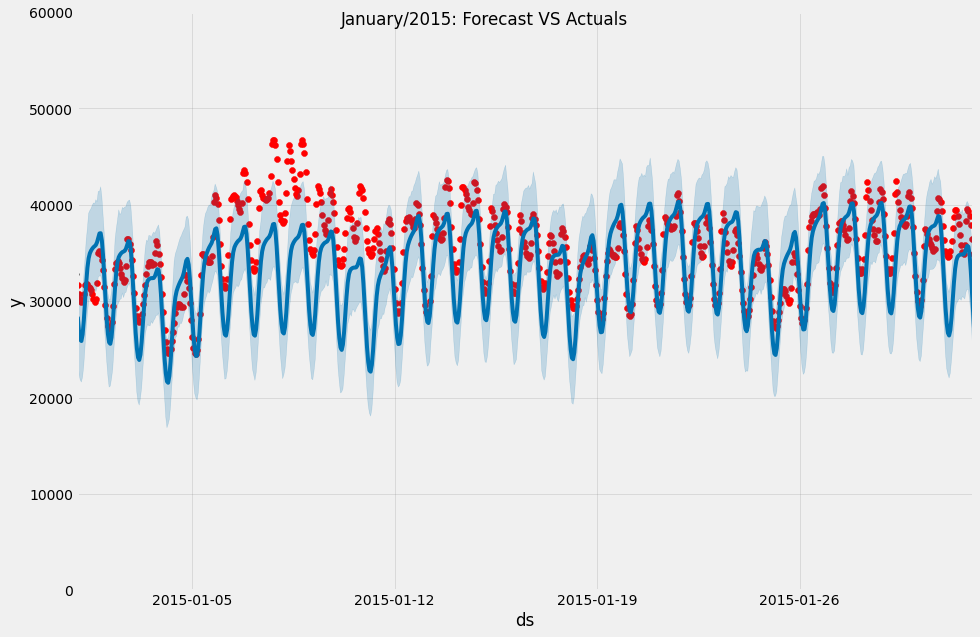

In [57]:
init = pd.to_datetime('01-01-2015', format = '%m-%d-%Y')
end = pd.to_datetime('02-01-2015', format = '%m-%d-%Y')

fig, ax = plt.subplots()

ax.scatter(x=pjme_test.index,
           y=pjme_test['PJME_MW'],
           color='r')

fig = model.plot(fcst=pjme_test_fcst,
                 ax=ax)

ax.set_xbound(lower=init,
             upper=end)
ax.set_ylim(0, 60_000)

plot = plt.suptitle(t='January/2015: Forecast VS Actuals\n')

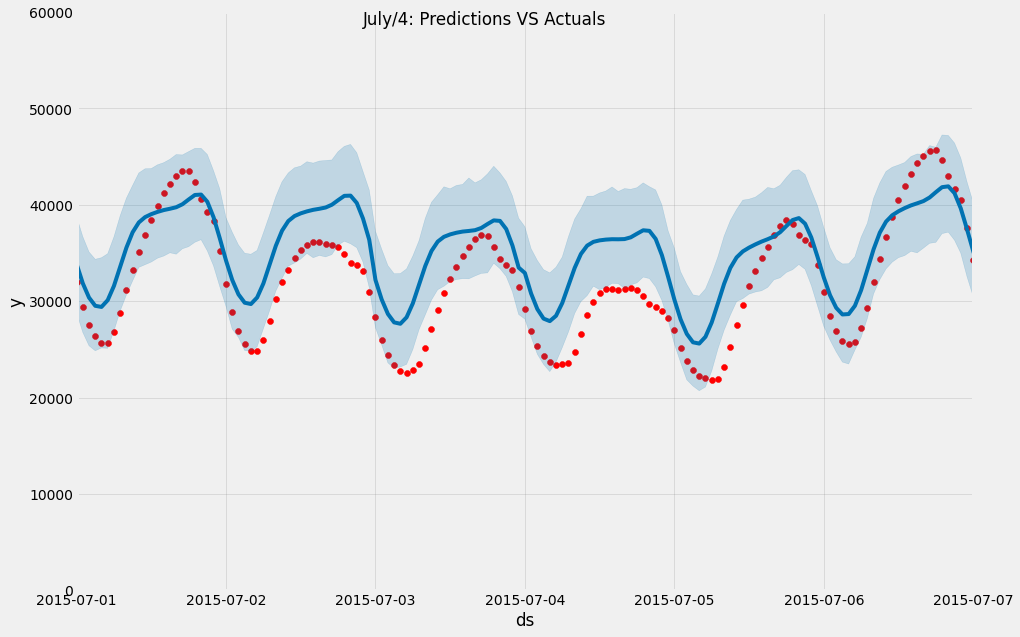

In [58]:
init = pd.to_datetime('07-01-2015', format = '%m-%d-%Y')
end = pd.to_datetime('07-07-2015', format = '%m-%d-%Y')

fig, ax = plt.subplots()

ax.scatter(x=pjme_test.index,
           y=pjme_test['PJME_MW'],
           color='r')

fig = model.plot(fcst=pjme_test_fcst_with_hols,
                 ax=ax)

ax.set_xbound(lower=init,
             upper=end)
ax.set_ylim(0, 60_000)

plot = plt.suptitle(t='July/4: Predictions VS Actuals\n')

In [59]:
np.sqrt(mse(y_true=pjme_test['PJME_MW'],
            y_pred=pjme_test_fcst_with_hols['yhat'])).round(4)

6626.601

In [60]:
mae(y_true=pjme_test['PJME_MW'], 
    y_pred=pjme_test_fcst_with_hols['yhat']).round(4)

5191.1797

In [61]:
mape = mean_absolute_percentage_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test_fcst_with_hols['yhat']
).round(4)

mape

16.5423

In [62]:
future = model.make_future_dataframe(
    periods=365*24,
    freq='h',
    include_history=False
)

future.head()

,ds
0,2015-01-01 01:00:00
1,2015-01-01 02:00:00
2,2015-01-01 03:00:00
3,2015-01-01 04:00:00
4,2015-01-01 05:00:00


In [63]:
forecast = model_with_holidays.predict(
    df=future
)

In [64]:
forecast[['yhat']].head()

,yhat
0,26722.506333
1,25219.030960
2,24347.855149
3,24206.477910
4,24880.671742
